In [1]:
import os
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing 
import math
import warnings
import operator
import re
from sklearn.preprocessing import StandardScaler

'''
My Own Algorithms Import
'''
from analysis.confusion_matrix import ConfusionMatrix
from analysis.cost import cost_function, sigmoidal_cost_function

#Ignore Warnings
warnings.filterwarnings("ignore")

#read data
salary_data = pd.read_csv('data-sets/Salary_Data.csv')
#randomize data with given seed
salary_data = salary_data.reindex(np.random.RandomState(seed=42).permutation(salary_data.index))

## Analyze the Data

In [2]:
salary_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 27 to 6
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  30 non-null     float64
 1   Salary           30 non-null     float64
dtypes: float64(2)
memory usage: 720.0 bytes


In [3]:
salary_data.head()

,YearsExperience,Salary
27,9.6,112635.0
15,4.9,67938.0
23,8.2,113812.0
17,5.3,83088.0
8,3.2,64445.0


## Visualize Data

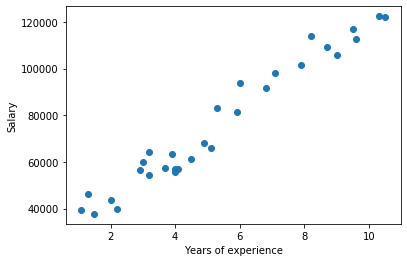

In [4]:
plt.scatter(salary_data['YearsExperience'], salary_data['Salary'])
plt.xlabel("Years of experience") 
plt.ylabel("Salary") 
plt.show()

## Scale and Split Data

In [5]:
standard_scaler = StandardScaler()
y_scaler = StandardScaler()

In [6]:
def train_test_split(data, y_label, x_scaler, y_scaler = None):
    x_data = data.drop([y_label], axis=1)
    y_data = data[y_label].values
    x_data_scaled = x_scaler.fit_transform(x_data)
    
    seventy_five__percentile = int(len(data)*0.75) 
    x_train, y_train = x_data[:seventy_five__percentile], y_data[:seventy_five__percentile]
    x_test, y_test = x_data[seventy_five__percentile:], y_data[seventy_five__percentile:]

    x_train_scaled = x_data_scaled[:seventy_five__percentile]
    x_test_scaled = x_data_scaled[seventy_five__percentile:]
    
    if y_scaler:
        y_data_scaled = y_scaler.fit_transform(y_data.reshape(-1, 1))
        y_train_scaled = y_data_scaled[:seventy_five__percentile].T[0]
        y_test_scaled = y_data_scaled[seventy_five__percentile:].T[0]
    else:
        y_train_scaled = y_train
        y_test_scaled = y_test
    return [x_train, y_train, x_test, y_test], [x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled]

In [7]:
[x_train, y_train, x_test, y_test], [x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled] = train_test_split(salary_data, "Salary", standard_scaler, y_scaler)

# Linear Regression

In [8]:
class LinearRegression:
    def fit(self, x_train, y_train, alpha = 0.01, regularization = 0.1, epochs=1000):
        '''
        using gradient descent for faster calculations
        '''
        # reshape x
        m_samples, n_features = x_train.shape
        x_train = x_train.T # X should have a sample per column X shape: (n features, m samples)
        x_train = np.insert(x_train, 0, np.ones((1, m_samples)), 0) 
        n_features = n_features + 1
        # randomize theta
        
        theta = np.random.rand(n_features, 1)
        self.cost_history = []
        # fit data
        for epoch in range(epochs):
            predictions = []
            for i in range(m_samples):
                gradient, prediction = self.gradient(x_train[:, i], y_train[i], theta, regularization)
                predictions.append(prediction)
                theta = theta - (alpha*gradient)
            cost = self.cost(predictions, y_train, theta, regularization)
            self.cost_history.append(cost)
                
        # save to model
        self.theta = theta
        self.x_train = x_train
        return self.theta
        
            
    def predict(self, x_test):
        m_samples, _ = x_test.shape
        x_test = x_test.T # X should have a sample per column X shape: (n features, m samples)
        x_test = np.insert(x_test, 0, np.ones((1, m_samples)), 0) 
        prediction = np.dot(self.theta.T, x_test)
        return prediction[0]
    
    def gradient(self, x, y, theta, regularization):
        prediction = np.dot(theta.T, x)[0]
        error = prediction - y
        x = x.reshape(-1, 1)
        theta_grad = np.insert(theta[1:], 0, 0, 0)*regularization
        gradient = np.dot(x, error)
        return gradient, prediction
        
    def cost(self, predictions, y, theta, regularization):
        return np.sum(np.square(predictions-y))/(2*len(y)) + (np.sum(np.square(theta[1:]))*regularization)/(2*len(y))
    
    def plot_cost_per_epoch(self):
        plt.plot(np.arange(0, len(self.cost_history), 1), self.cost_history)

In [9]:
linearRegression = LinearRegression()
linearRegression.fit(x_train_scaled, y_train_scaled, alpha = 0.1, regularization = 0.01, epochs=4)

array([[-0.01155912],
       [ 0.98329318]])

## Test Implementation

In [10]:
predictions = y_scaler.inverse_transform(linearRegression.predict(x_test_scaled))
predictions

array([ 81264.04593243, 124958.3471553 ,  89812.93095429,  55617.39086683,
        62266.52366161,  67965.78034286,  82213.92204597,  53717.63863975])

## Plot Regression Line

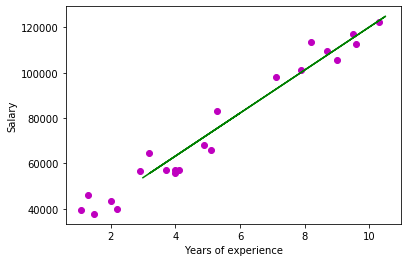

In [11]:
plt.scatter(x_train.values[:, 0], y_train, color = "m", 
               marker = "o") 
plt.plot(x_test, predictions, color = "g")
plt.xlabel("Years of experience") 
plt.ylabel("Salary") 
plt.show()

## Plot Cost Per Epoch

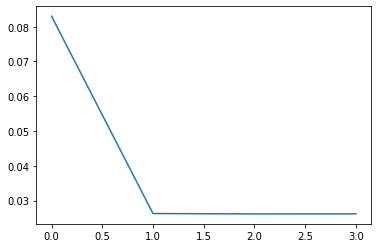

In [12]:
linearRegression.plot_cost_per_epoch()

## Cost function

In [13]:
cost_function(predictions, y_test)

15086576.21688196

## Compare with sklearn

In [14]:
from sklearn.linear_model import LinearRegression as skLinearRegression
reg = skLinearRegression()
reg.fit(x_train_scaled, y_train_scaled)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
skpredictions = reg.predict(x_test_scaled)
skpredictions

array([ 0.19427465,  1.81694699,  0.51175402, -0.75816346, -0.51123506,
       -0.29958215,  0.22955013, -0.82871444])

In [16]:
cost_function(y_scaler.inverse_transform(skpredictions), y_test)

15140184.169832392

# Linear Regression with multiple features

## Predict Startup Profit

In [17]:
#read data
startup_data = pd.read_csv('data-sets/50_Startups.csv')
#randomize data with given seed
startup_data = startup_data.reindex(np.random.RandomState(seed=42).permutation(startup_data.index))

## Analyze the data

In [18]:
startup_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 13 to 38
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.3+ KB


In [19]:
startup_data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
13,91992.39,135495.07,252664.93,California,134307.35
39,38558.51,82982.09,174999.30,California,81005.76
30,61994.48,115641.28,91131.24,Florida,99937.59
45,1000.23,124153.04,1903.93,New York,64926.08
17,94657.16,145077.58,282574.31,New York,125370.37


## Visualize Data

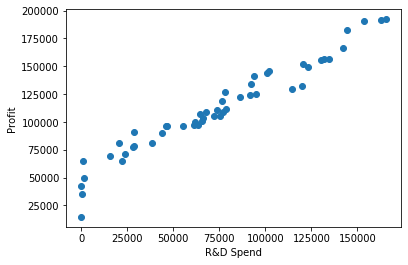

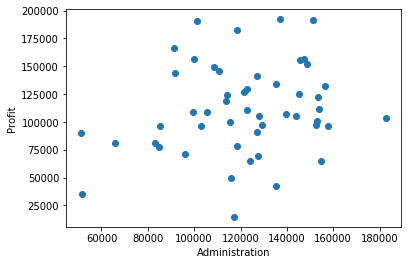

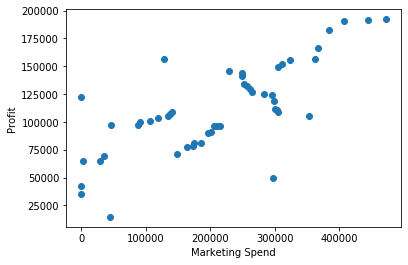

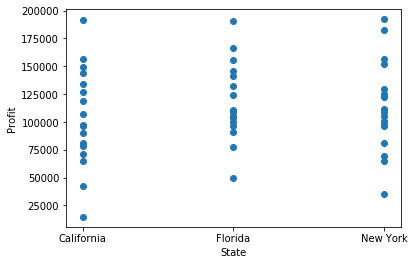

In [20]:
def scatterTable(x_train, y, y_label):
    for column in x_train.columns:
        plt.scatter(x_train[column], y, marker = "o") 
        plt.xlabel(column) 
        plt.ylabel(y_label) 
        plt.show()
        
profit_column = startup_data['Profit'].values
other_columns = startup_data.drop(['Profit'], axis = 1)
scatterTable(other_columns, profit_column, 'Profit')

## Set up data

In [21]:
startup_data = startup_data.drop(['State'], axis = 1)

In [22]:
standard_scaler = StandardScaler()
y_scaler = StandardScaler()

In [23]:
[x_train, y_train, x_test, y_test], [x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled] = train_test_split(startup_data, "Profit", standard_scaler, y_scaler)

In [24]:
linearRegression = LinearRegression()
linearRegression.fit(x_train_scaled, y_train_scaled, alpha = 0.07, epochs=10)

array([[ 0.04568803],
       [ 0.89439028],
       [-0.01337059],
       [ 0.09301061]])

In [25]:
predictions = y_scaler.inverse_transform(linearRegression.predict(x_test_scaled))
predictions

array([ 92604.74403393, 112148.74934762,  77402.34542404, 136738.63348383,
       116851.68471815, 130703.36014298,  50937.73951428, 118654.82272707,
       161262.50201301,  73056.44905157, 150853.25823831, 103785.58805093,
        72101.3938155 ])

In [26]:
cost_function(predictions, y_test)

75503327.45205161

## Plot Cost per epoch

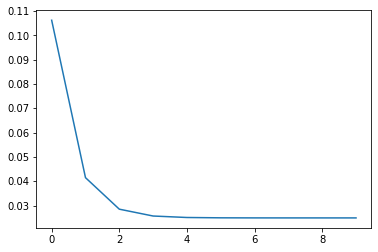

In [27]:
linearRegression.plot_cost_per_epoch()

## Compare with sklearn

In [28]:
reg = skLinearRegression()
reg.fit(x_train_scaled, y_train_scaled)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
skpredictions = y_scaler.inverse_transform(reg.predict(x_test_scaled))
skpredictions

array([ 89654.78415453, 109894.02715908,  75998.78028454, 135337.66580877,
       115444.80406273, 129087.47708776,  49788.11828987, 116876.27332202,
       161292.58276188,  70687.9377109 , 151605.17186022, 105903.06666229,
        68140.90766027])

In [30]:
cost_function(skpredictions, y_test)

77848636.69752574

# Logistic Regression

## Predict Breast Cancer

In [31]:
#read data
breast_cancer_df = pd.read_csv('data-sets/Breast_cancer_data.csv')
#randomize data with given seed
breast_cancer_df = breast_cancer_df.reindex(np.random.RandomState(seed=42).permutation(breast_cancer_df.index))

## Analyze the data

In [32]:
breast_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 204 to 102
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 31.1 KB


In [33]:
breast_cancer_df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
204,12.47,18.60,81.09,481.9,0.09965,1
70,18.94,21.31,123.60,1130.0,0.09009,0
131,15.46,19.48,101.70,748.9,0.10920,0
431,12.40,17.68,81.47,467.8,0.10540,1
540,11.54,14.44,74.65,402.9,0.09984,1


## Visualize the data

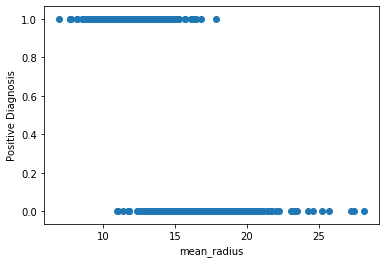

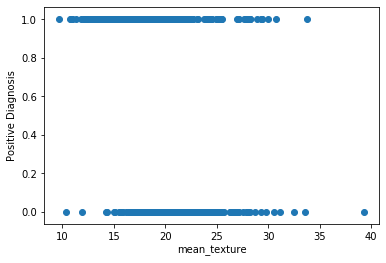

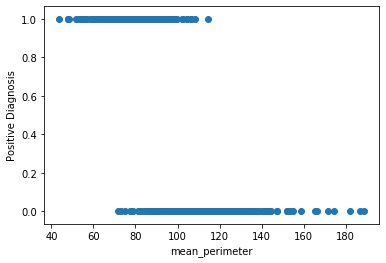

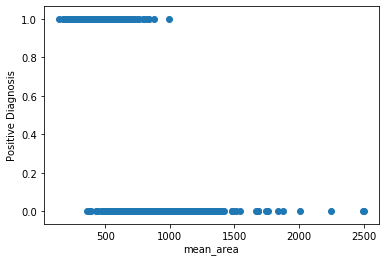

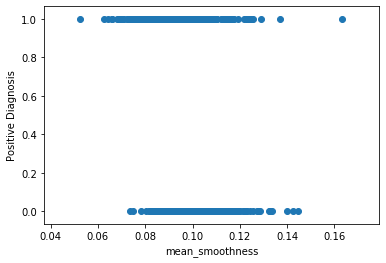

In [34]:
diagnosis_column = breast_cancer_df['diagnosis'].values
other_columns = breast_cancer_df.drop(['diagnosis'], axis = 1)
scatterTable(other_columns, diagnosis_column, 'Positive Diagnosis')

## Set up Data

In [35]:
breast_cancer_df.drop(['mean_texture', 'mean_smoothness'], axis=1, inplace=True)

In [36]:
standard_scaler = StandardScaler()

In [37]:
[x_train, y_train, x_test, y_test], [x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled] = train_test_split(breast_cancer_df, "diagnosis", standard_scaler)

# Logistic Regression

In [38]:
class LogisticRegression:
    def fit(self, x_train, y_train, alpha = 0.01, regularization = 0.1, epochs=100):
        '''
        using gradient descent for faster calculations
        '''
        # reshape x
        m_samples, n_features = x_train.shape
        x_train = x_train.T # X should have a sample per column X shape: (n features, m samples)
        x_train = np.insert(x_train, 0, np.ones((1, m_samples)), 0) 
        n_features = n_features + 1
        # randomize theta
        
        theta = np.random.rand(n_features, 1)
        self.cost_history = []
        # fit data
        for epoch in range(epochs):
            predictions = []
            for i in range(m_samples):
                gradient, prediction = self.gradient(x_train[:, i], y_train[i], theta, regularization)
                predictions.append(prediction)
                theta = theta - (alpha*gradient)
            cost = self.cost(predictions, y_train, theta, regularization)
            self.cost_history.append(cost)
                
        # save to model
        self.theta = theta
        self.x_train = x_train
        return self.theta
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
        
            
    def predict(self, x_test):
        m_samples, _ = x_test.shape
        x_test = x_test.T # X should have a sample per column X shape: (n features, m samples)
        x_test = np.insert(x_test, 0, np.ones((1, m_samples)), 0) 
        prediction = self.sigmoid(np.dot(self.theta.T, x_test))
        return prediction[0]
    
    def gradient(self, x, y, theta, regularization):
        prediction = self.sigmoid(np.dot(theta.T, x))[0]
        error = prediction - y
        x = x.reshape(-1, 1)
        theta_grad = np.insert(theta[1:], 0, 0, 0)*regularization
        gradient = np.dot(x, error)
        return gradient, prediction
        
    def cost(self, predictions, y, theta, regularization):
        return -np.sum(y*np.log(predictions)+((1-y)*np.log([1-p for p in predictions])))/len(y)
    
    def plot_cost_per_epoch(self):
        plt.plot(np.arange(0, len(self.cost_history), 1), self.cost_history)

In [39]:
logisticRegression = LogisticRegression()

In [40]:
logisticRegression.fit(x_train_scaled, y_train, alpha = 0.1)

array([[ 0.89112647],
       [ 6.63640573],
       [-9.98422775],
       [-0.53653435]])

## Plot Sigmoid

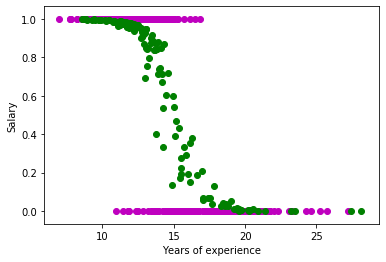

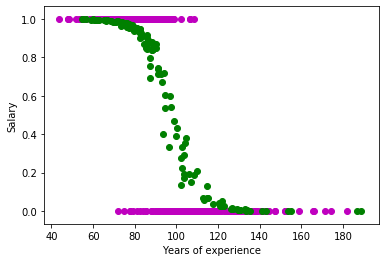

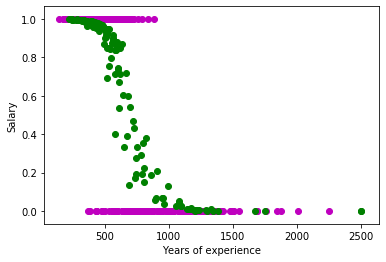

In [41]:
predictions = logisticRegression.predict(x_test_scaled)
for i in range(x_test.shape[1]):
    plt.scatter(x_train.values[:, i], y_train, color = "m", 
                   marker = "o") 
    plt.scatter(x_test.values[:, i], predictions, color = "g")
    plt.xlabel("Years of experience") 
    plt.ylabel("Salary") 
    plt.show()

## Plot cost per epoch

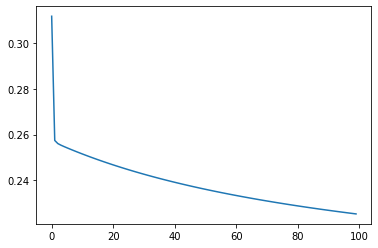

In [42]:
logisticRegression.plot_cost_per_epoch()

## Predict

In [43]:
breast_cancer_diagnosis_probabilities = logisticRegression.predict(x_test_scaled)
breast_cancer_diagnosis_normalized = [1 if p > 0.5 else 0 for p in breast_cancer_diagnosis_probabilities]

## Confusion Matrix

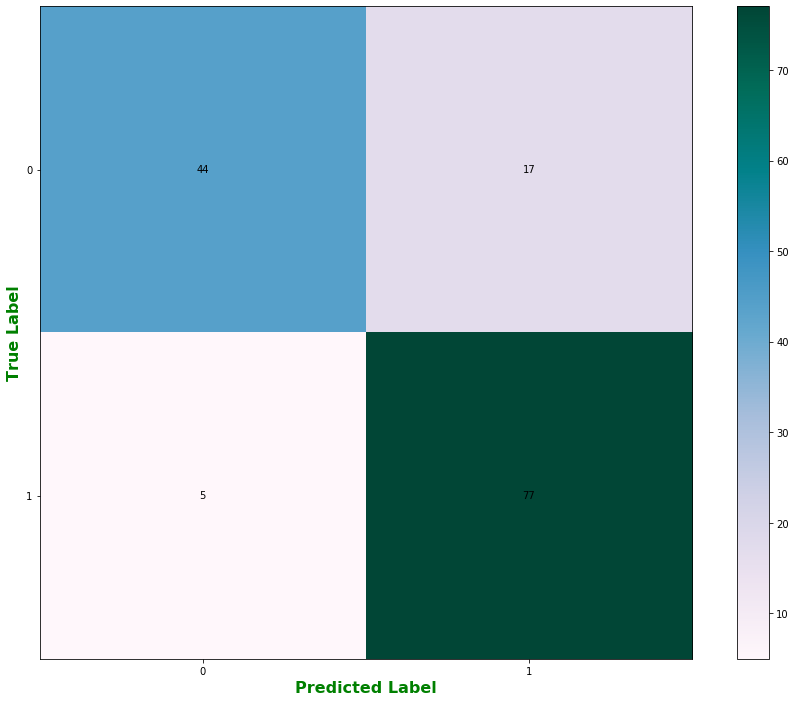

In [44]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(breast_cancer_diagnosis_normalized, y_test)
confusion_matrix.plot()

## Compare with SKLearn

In [45]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x_train_scaled, y_train)
skpredictions = clf.predict(x_test_scaled)

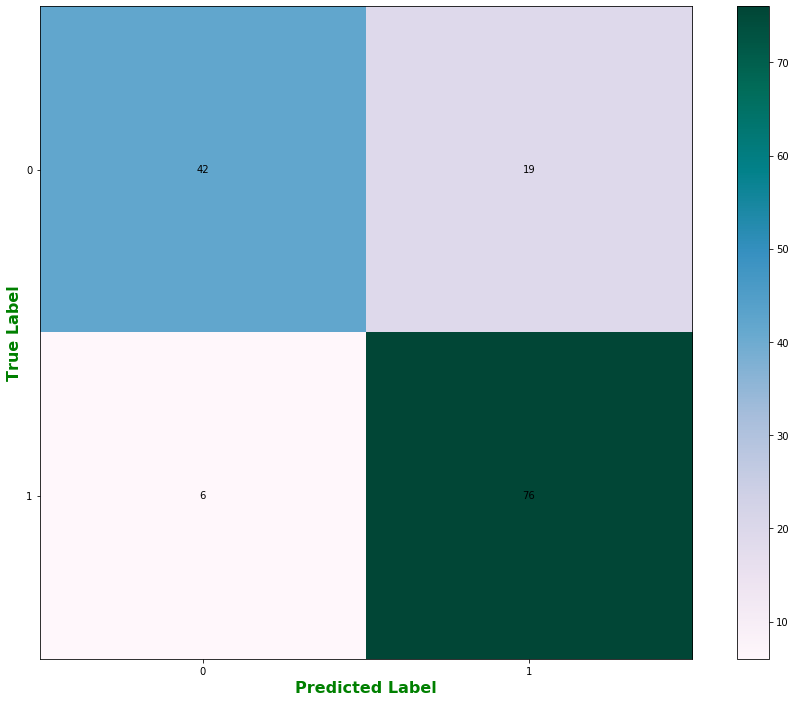

In [46]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(skpredictions, y_test)
confusion_matrix.plot()